In [1]:
%matplotlib inline
import pandas as pd

In [2]:
purchases = pd.read_csv("../data/treated/purchases_enriched.csv")

## Trying a supervised model

In [3]:
data = purchases.copy()
for i, column in enumerate(list([str(d) for d in data.dtypes])):
    if column == "object":
        data[data.columns[i]] = data[data.columns[i]].fillna(data[data.columns[i]].mode())
        data[data.columns[i]] = data[data.columns[i]].astype("category").cat.codes
    else:
        data[data.columns[i]] = data[data.columns[i]].fillna(data[data.columns[i]].median())

In [4]:
data.head()

,Unnamed: 0,NUM BEN,BENEFICIARIO,RFC,FACTURA,CONTRATO,CONCEPTO,TIPO,# OP,FECHA,IMPORTE,SHEET,DIA,MES,ANO,BENEFICIARIO_SALES,HAS_LINKEDIN
0,0,110152,161,167,1388,130,780,1,1019110.0,8,14911.80,2,11,12,2020,13,True
1,1,110152,161,167,1389,135,845,1,1019110.0,8,2528.80,2,11,12,2020,13,True
2,2,110152,161,167,1390,132,759,1,1019110.0,8,8500.02,2,11,12,2020,13,True
3,3,110152,161,167,1391,131,757,1,1019110.0,8,2400.01,2,11,12,2020,13,True
4,4,110152,161,167,1392,417,859,1,299001496.0,16,1537.00,2,23,12,2020,13,True


In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [6]:
y = data.pop("IMPORTE")
X = data.copy()
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [7]:
clf = RandomForestRegressor(n_estimators=1000, max_depth=4)
clf.fit(X_train, y_train)

RandomForestRegressor(max_depth=4, n_estimators=1000)

In [8]:
r2_score(y_test, clf.predict(X_test))

0.18673857272385685

## Testing non-supervised model or clustering for the text

In [9]:
import gensim
from nltk.corpus import stopwords
import numpy as np
np.random.seed(2021)

In [10]:
# Convert the data into tokens
def preprocess(text):
    result = []
    for token in text.split():
        if token not in stopwords.words("spanish") and len(token)>4:
            result.append(token)

    return result

In [11]:
process_business = [preprocess(x) for x in list(purchases["BENEFICIARIO"].unique())]

In [12]:
dictionary = gensim.corpora.Dictionary(process_business)

In [13]:
dictionary.filter_extremes(no_below=1, no_above=0.5)

In [14]:
bow_corpus = [dictionary.doc2bow(doc) for doc in process_business]

In [15]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=6,id2word=dictionary, passes = 10, workers=2)

In [16]:
for idx, type_business in lda_model.print_topics(-1):
    print("topic: {} Words: {}".format(idx, type_business))

topic: 0 Words: 0.010*"DESARROLLOS" + 0.010*"GARZA" + 0.010*"GUERRERO" + 0.010*"INSTITUTO" + 0.010*"SALAZAR" + 0.010*"ADRIANA" + 0.010*"BANCO" + 0.010*"URBANIZACIONES" + 0.010*"IGNACIO" + 0.010*"JESUS"
topic: 1 Words: 0.033*"GARCIA" + 0.021*"GONZALEZ" + 0.021*"GARZA" + 0.018*"MARIA" + 0.013*"TREVIÑO" + 0.013*"SANCHEZ" + 0.013*"MARCELO" + 0.013*"ARTURO" + 0.013*"MANUEL" + 0.009*"ALBERTO"
topic: 2 Words: 0.015*"GRUPO" + 0.010*"SERVICIOS" + 0.010*"ESTHER" + 0.010*"MARTINEZ" + 0.010*"MONTERREY" + 0.010*"CONSTRUCTORA" + 0.010*"MORENO" + 0.005*"ALEJANDRO" + 0.005*"VILLARREAL" + 0.005*"HERNANDEZ"
topic: 3 Words: 0.026*"MARIA" + 0.023*"RODRIGUEZ" + 0.019*"GONZALEZ" + 0.018*"GOMEZ" + 0.012*"LOZANO" + 0.008*"TORRES" + 0.008*"DESARROLLO" + 0.008*"PEREZ" + 0.008*"SEGURIDAD" + 0.008*"SANCHEZ"
topic: 4 Words: 0.031*"CONSTRUCTORA" + 0.018*"CONSTRUCCIONES" + 0.018*"MEXICO," + 0.010*"NUEVO" + 0.010*"RAMIREZ" + 0.010*"SEGUROS" + 0.010*"INTEGRACION" + 0.010*"SEBASTIAN," + 0.010*"ARRENDADORA" + 0.010*"GRU

In [17]:
def get_max_topic(index):
    results = lda_model[bow_corpus[index]]
    return max(lda_model[results], key=lambda x: x[1])[0]

In [18]:
business_cluster = {x: get_max_topic(i) for i, x in enumerate(list(purchases["BENEFICIARIO"].unique()))}

In [19]:
purchases["CLUSTER_NAME"] = purchases["BENEFICIARIO"].apply(lambda x: business_cluster[x])

<AxesSubplot:xlabel='CLUSTER_NAME'>

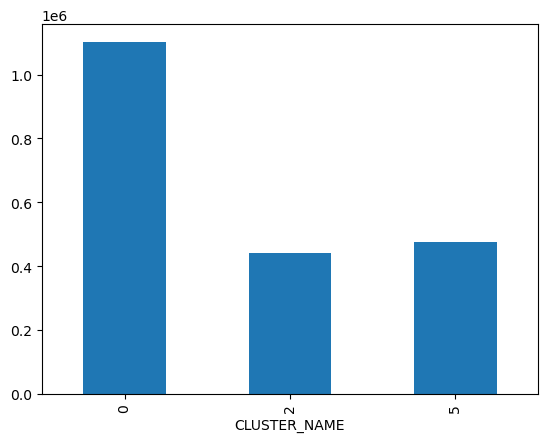

In [20]:
purchases.groupby("CLUSTER_NAME")["IMPORTE"].mean().plot.bar()

## Trying a non-supervised model of animalies for "importes"

In [21]:
import numpy as np
from scipy.stats import norm

In [22]:
params = norm.fit(purchases["IMPORTE"])
params

(626317.9473441559, 4665396.47441213)

In [24]:
purchases["PROB_TOTAL"] = [norm(params[0], params[1]).cdf(x) for x in purchases["IMPORTE"]]

In [26]:
purchases[purchases["PROB_TOTAL"]>0.95]

,Unnamed: 0,NUM BEN,BENEFICIARIO,RFC,FACTURA,CONTRATO,CONCEPTO,TIPO,# OP,FECHA,IMPORTE,SHEET,DIA,MES,ANO,BENEFICIARIO_SALES,HAS_LINKEDIN,CLUSTER_NAME,PROB_TOTAL
283,336,116684,"INDUSTRIAS SOLA BASIC, S.A. DE C.V.",ISB840628IB2,GS106845-158003-5868,SSP-189-2017,MANTENIMIENTO PREVENTIVO Y CORRECTIVO DE LOS T...,TR,604000051.0,2020-12-30,9.000000e+06,GASTOS VARIOS,30,12,2020,2,True,2,0.963661
353,415,126224,"BANCO MULTIVA, SA. G.F.M.",BMI061005NY5,FS-23-2020-158004-1712,NO APLICA,FONDO SAPS 23-2020,TR,1019137.0,2020-12-11,9.071256e+06,GASTOS VARIOS,11,12,2020,2,True,0,0.964862
354,416,126224,"BANCO MULTIVA, SA. G.F.M.",BMI061005NY5,FS-24-2020-158004-1751,NO APLICA,FONDO SAPS 24-2020,TR,1019152.0,2020-12-18,9.078245e+06,GASTOS VARIOS,18,12,2020,2,True,0,0.964978
357,421,126671,"BANCO BANCREA,S.A. ,FIDEICOMISO NUMERO BP417",BBA130722BR7,144-153001-167,NO APLICA,APORTACIÓN MUNICIPAL AL FIDEICOMISO LA GRAN CI...,TR,1019122.0,2020-12-11,3.000000e+07,GASTOS VARIOS,11,12,2020,1,False,0,1.000000
367,438,206894,MUNICIPIO DE LA CIUDAD DE MONTERREY,MCM610101PT2,2020-23-A-158004-1734,NO APLICA,"PAGO DE NÓMINA PERIODO: 23-2020, BANCO: BANCA ...",TR,11000196.0,2020-12-17,7.386437e+07,GASTOS VARIOS,17,12,2020,16,True,0,1.000000
368,439,206894,MUNICIPIO DE LA CIUDAD DE MONTERREY,MCM610101PT2,2020-23-B-158004-1735,NO APLICA,"PAGO DE NÓMINA PERIODO: 23-2020, BANCO: BANCO ...",TR,231000103.0,2020-12-17,7.635249e+07,GASTOS VARIOS,17,12,2020,16,True,0,1.000000
369,440,206894,MUNICIPIO DE LA CIUDAD DE MONTERREY,MCM610101PT2,2020-23-C-158004-1733,NO APLICA,"PAGO DE NÓMINA PERIODO: 23-2020, BANCO: BANCO ...",TR,240000108.0,2020-12-17,1.924614e+07,GASTOS VARIOS,17,12,2020,16,True,0,0.999967
370,441,206894,MUNICIPIO DE LA CIUDAD DE MONTERREY,MCM610101PT2,2020-24-A-158004-1760,NO APLICA,"PAGO DE NÓMINA PERIODO: 24-2020, BANCO: BANCA ...",TR,11000197.0,2020-12-28,3.610189e+07,GASTOS VARIOS,28,12,2020,16,True,0,1.000000
372,443,206894,MUNICIPIO DE LA CIUDAD DE MONTERREY,MCM610101PT2,2020-24-B-158004-1761,NO APLICA,"PAGO DE NÓMINA PERIODO: 24-2020, BANCO: BANCO ...",TR,231000104.0,2020-12-28,3.357936e+07,GASTOS VARIOS,28,12,2020,16,True,0,1.000000
374,445,206894,MUNICIPIO DE LA CIUDAD DE MONTERREY,MCM610101PT2,2020-24-C-158004-1759,NO APLICA,"PAGO DE NÓMINA PERIODO: 24-2020, BANCO: BANCO ...",TR,240000109.0,2020-12-28,1.336286e+07,GASTOS VARIOS,28,12,2020,16,True,0,0.996833


In [27]:
models_sheet = {}
for sheet in list(purchases["SHEET"].unique()):
    sheet_compras = purchases[purchases["SHEET"] == sheet]
    params = norm.fit(sheet_compras["IMPORTE"])
    models_sheet[sheet] = norm(params[0], params[1])

<AxesSubplot:>

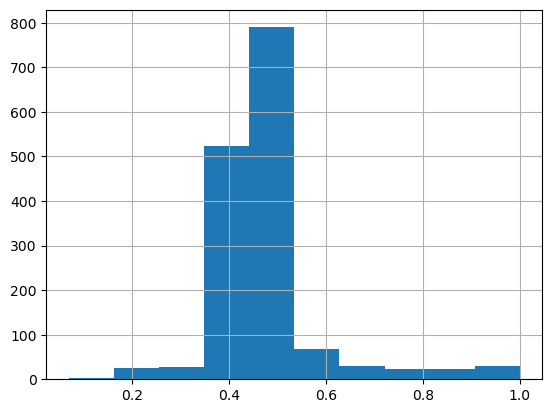

In [29]:
sheet_prob = []
for i, row in purchases.iterrows():
    sheet_prob.append(models_sheet[row["SHEET"]].cdf(row["IMPORTE"]))

purchases["PROB_SHEET"] = sheet_prob
purchases["PROB_SHEET"].hist()

In [30]:
purchases[purchases["PROB_SHEET"]>0.95]

,Unnamed: 0,NUM BEN,BENEFICIARIO,RFC,FACTURA,CONTRATO,CONCEPTO,TIPO,# OP,FECHA,IMPORTE,SHEET,DIA,MES,ANO,BENEFICIARIO_SALES,HAS_LINKEDIN,CLUSTER_NAME,PROB_TOTAL,PROB_SHEET
283,336,116684,"INDUSTRIAS SOLA BASIC, S.A. DE C.V.",ISB840628IB2,GS106845-158003-5868,SSP-189-2017,MANTENIMIENTO PREVENTIVO Y CORRECTIVO DE LOS T...,TR,604000051.0,2020-12-30,9.000000e+06,GASTOS VARIOS,30,12,2020,2,True,2,0.963661,0.953737
353,415,126224,"BANCO MULTIVA, SA. G.F.M.",BMI061005NY5,FS-23-2020-158004-1712,NO APLICA,FONDO SAPS 23-2020,TR,1019137.0,2020-12-11,9.071256e+06,GASTOS VARIOS,11,12,2020,2,True,0,0.964862,0.955151
354,416,126224,"BANCO MULTIVA, SA. G.F.M.",BMI061005NY5,FS-24-2020-158004-1751,NO APLICA,FONDO SAPS 24-2020,TR,1019152.0,2020-12-18,9.078245e+06,GASTOS VARIOS,18,12,2020,2,True,0,0.964978,0.955287
357,421,126671,"BANCO BANCREA,S.A. ,FIDEICOMISO NUMERO BP417",BBA130722BR7,144-153001-167,NO APLICA,APORTACIÓN MUNICIPAL AL FIDEICOMISO LA GRAN CI...,TR,1019122.0,2020-12-11,3.000000e+07,GASTOS VARIOS,11,12,2020,1,False,0,1.000000,1.000000
367,438,206894,MUNICIPIO DE LA CIUDAD DE MONTERREY,MCM610101PT2,2020-23-A-158004-1734,NO APLICA,"PAGO DE NÓMINA PERIODO: 23-2020, BANCO: BANCA ...",TR,11000196.0,2020-12-17,7.386437e+07,GASTOS VARIOS,17,12,2020,16,True,0,1.000000,1.000000
368,439,206894,MUNICIPIO DE LA CIUDAD DE MONTERREY,MCM610101PT2,2020-23-B-158004-1735,NO APLICA,"PAGO DE NÓMINA PERIODO: 23-2020, BANCO: BANCO ...",TR,231000103.0,2020-12-17,7.635249e+07,GASTOS VARIOS,17,12,2020,16,True,0,1.000000,1.000000
369,440,206894,MUNICIPIO DE LA CIUDAD DE MONTERREY,MCM610101PT2,2020-23-C-158004-1733,NO APLICA,"PAGO DE NÓMINA PERIODO: 23-2020, BANCO: BANCO ...",TR,240000108.0,2020-12-17,1.924614e+07,GASTOS VARIOS,17,12,2020,16,True,0,0.999967,0.999929
370,441,206894,MUNICIPIO DE LA CIUDAD DE MONTERREY,MCM610101PT2,2020-24-A-158004-1760,NO APLICA,"PAGO DE NÓMINA PERIODO: 24-2020, BANCO: BANCA ...",TR,11000197.0,2020-12-28,3.610189e+07,GASTOS VARIOS,28,12,2020,16,True,0,1.000000,1.000000
372,443,206894,MUNICIPIO DE LA CIUDAD DE MONTERREY,MCM610101PT2,2020-24-B-158004-1761,NO APLICA,"PAGO DE NÓMINA PERIODO: 24-2020, BANCO: BANCO ...",TR,231000104.0,2020-12-28,3.357936e+07,GASTOS VARIOS,28,12,2020,16,True,0,1.000000,1.000000
374,445,206894,MUNICIPIO DE LA CIUDAD DE MONTERREY,MCM610101PT2,2020-24-C-158004-1759,NO APLICA,"PAGO DE NÓMINA PERIODO: 24-2020, BANCO: BANCO ...",TR,240000109.0,2020-12-28,1.336286e+07,GASTOS VARIOS,28,12,2020,16,True,0,0.996833,0.995149


## Conclusions

* To state the central tendency
* There are histories on outliers
* Make an effort to respond the original question
* if the focus or original question changed, document it